# Kaggle : Avito Demand Prediction Challenge

In [1]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Initially forked from Bojan's kernel here: https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2242/code
#improvement using kernel from Nick Brook's kernel here: https://www.kaggle.com/nicapotato/bow-meta-text-and-dense-features-lgbm
#Used oof method from Faron's kernel here: https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867
#Used some text cleaning method from Muhammad Alfiansyah's kernel here: https://www.kaggle.com/muhammadalfiansyah/push-the-lgbm-v19
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
# print("Data:\n",os.listdir("../input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

#warning
import warnings
warnings.filterwarnings("ignore")

/home/jk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
NFOLDS = 5
SEED = 42
VALID = False
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [4]:
print("\nData Load Stage")
training = pd.read_csv('../train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('../test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index

ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))


print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))


Data Load Stage
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns
Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [5]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [6]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

In [7]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 10.65 Minutes


In [8]:
%%time
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':20.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23044451776924724
CPU times: user 8min 5s, sys: 2.98 s, total: 8min 8s
Wall time: 8min 8s


In [9]:
print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
print(X.shape)
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

print("\nModeling Stage")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)

del ridge_preds,vectorizer,ready_df
gc.collect();

Modeling Stage
(1503424, 1430783)
1503424 Rows and 1430783 Cols
508438 Rows and 1430783 Cols
Feature Names Length:  1430783

Modeling Stage


In [10]:
X.shape, y.shape, testing.shape

((1503424, 1430783), (1503424,), (508438, 1430783))

In [11]:
# # %%time

# model_lgb  = lgb.LGBMRegressor(max_depth=-1, num_leaves=270, feature_fraction=0.5, bagging_fraction=0.75, bagging_freq=5, learning_rate=0.018, n_estimators=400, reg_lambda=0.5, n_jobs=-1).fit(X, y)

In [12]:
# y_pred = model_lgb.predict(testing)

# sample_submission = pd.read_csv("../sample_submission.csv")

# sub = pd.DataFrame(columns= ['item_id', 'deal_probability'])
# sub['item_id'] = sample_submission["item_id"]
# sub['deal_probability'] = y_pred.clip(0.0, 1.0)
# sub.to_csv('sample_submission.csv',index=False)

# ! kaggle competitions submit -c avito-demand-prediction -f sample_submission.csv -m "Message"

In [13]:
# 0.2224
# lgbm_params =  {
#     'max_depth': -1,
#     'num_leaves': 270,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.75,
#     # 'bagging_freq': 5,
#     'learning_rate': 0.018,
#     'verbose': 0
#     'reg_lambda' : 0
# }  

# 0.2223
# lgbm_params =  {
#     'max_depth': -1,
#     'num_leaves': 270,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.75,
#     # 'bagging_freq': 5,
#     'learning_rate': 0.018,
#     'verbose': 0,
#     'reg_lambda' : 0.5
# }  

# 0.2224
# lgbm_params =  {
#     'max_depth': -1,
#     'num_leaves': 270,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.75,
#     # 'bagging_freq': 5,
#     'learning_rate': 0.018,
#     'verbose': 0,
#     'reg_alpha' : 0.5,        
#     'reg_lambda' : 0.5
# }  


In [26]:
%%time
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.015,
    'n_jobs' : -1,
    'verbose': 0,
    'reg_rambda' : 0.5,
}  


if VALID == True:
    print("1")
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=23)
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=4000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    print("2")
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
#     del X; 
    gc.collect()
    # Go Go Go
    evals_result = {}

    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=8000,
        verbose_eval=100,
    )

Light Gradient Boosting Regressor
2
(1353081, 1430783) (150343, 1430783) (1353081,) (150343,)
CPU times: user 16h 39min 17s, sys: 1h 38min 1s, total: 18h 17min 19s
Wall time: 2h 17min 58s


In [27]:
gc.collect()

41

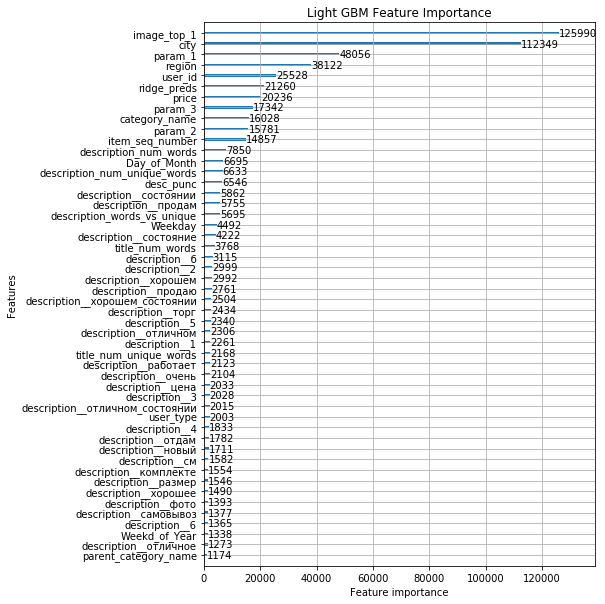

Model Evaluation Stage
Notebook Runtime: 488.76 Minutes
Successfully submitted to Avito Demand Prediction Challenge

In [33]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()
# lgb_clf.feature_importance_

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("submission.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

! kaggle competitions submit -c avito-demand-prediction -f submission.csv -m "Message"

In [17]:
# print("feature importance mean :", round(np.mean(lgb_clf.feature_importances_), 2))
# print("feature importance median :", round(np.median(lgb_clf.feature_importances_), 2))

In [18]:
# # Feature Importance Plot
# f, ax = plt.subplots(figsize=[7,10])
# lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
# plt.title("Light GBM Feature Importance")
# plt.savefig('feature_import.png')
# plt.show()
# # lgb_clf.feature_importance_

# print("Model Evaluation Stage")
# lgpred = lgb_clf.predict(testing) 

# #Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
# #blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
# lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
# lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
# lgsub.to_csv("submission.csv",index=True,header=True)
# #print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
# print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

# feature selection

In [49]:
gc.collect()

339

In [48]:
X.shape, y.shape, testing.shape

((1503424, 1430783), (1503424,), (508438, 1430783))

In [45]:
type(X)

scipy.sparse.coo.coo_matrix

In [47]:
X.toarray()

MemoryError: 

In [42]:
X.fillna(X.mean())

AttributeError: fillna not found

In [38]:
X = X.as_matrix().astype(np.float)
testing = testing.as_matrix().astype(np.float)
y = y.as_matrix().astype(np.float)

AttributeError: as_matrix not found

In [25]:
from sklearn.feature_selection import SelectFromModel

model1 = SelectFromModel(lgb_clf, prefit=True, threshold=100)
X = model1.transform(X)
testing = model1.transform(testing)

X.shape, y.shape, testing.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.015,
    'n_jobs' : -1,
    'verbose': 0
}  


if VALID == True:
    print("1")
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=23)
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=2000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    print("2")
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
#     del X; 
    gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=2000,
        verbose_eval=100
    )

In [ ]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')
plt.show()
# lgb_clf.feature_importance_

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("submission.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

In [ ]:
! kaggle competitions submit -c avito-demand-prediction -f submission.csv -m "Message"